In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [42]:
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error,r2_score,confusion_matrix
from sklearn.model_selection import learning_curve,cross_val_score,validation_curve,train_test_split,KFold

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor,plot_importance
import joblib

In [4]:
data = pd.read_csv('train_NIR5Yl1.csv')

In [5]:
data.head(6)

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0
5,345568,r,440.0,1.0,23866,5577.0,4.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330045 entries, 0 to 330044
Data columns (total 7 columns):
ID            330045 non-null int64
Tag           330045 non-null object
Reputation    330045 non-null float64
Answers       330045 non-null float64
Username      330045 non-null int64
Views         330045 non-null float64
Upvotes       330045 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 17.6+ MB


In [7]:
for col in data.columns:
    print(col,data[col].nunique())

ID 330045
Tag 10
Reputation 16527
Answers 63
Username 141802
Views 82137
Upvotes 7239


In [8]:
sum_df = data.groupby(by='Tag').sum()
avg_df = data.groupby(by='Tag').mean()

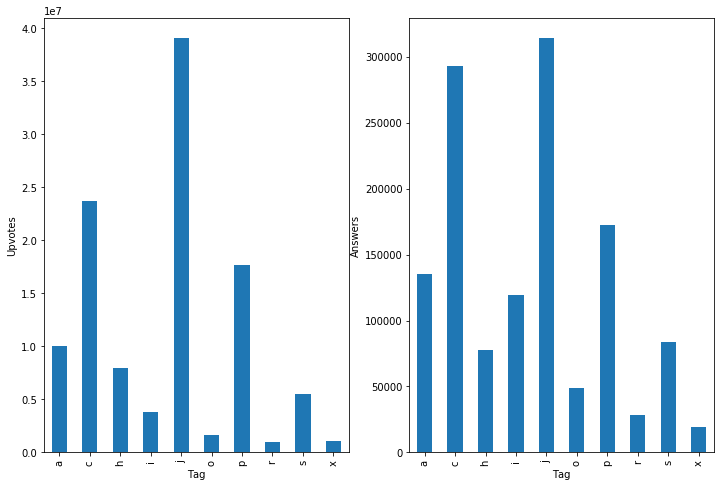

In [9]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sum_df['Upvotes'].plot(kind='bar',cmap='tab20')
plt.ylabel('Upvotes')
plt.subplot(1,2,2)
sum_df['Answers'].plot(kind='bar',cmap='tab20')
plt.ylabel('Answers')
plt.show()

In [12]:
corr_matrix = data[['Reputation','Answers','Username','Views','Upvotes']].corr()

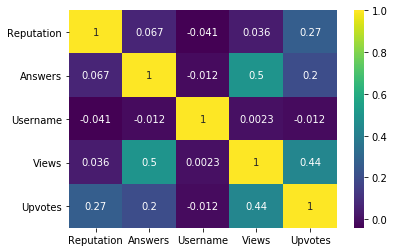

In [13]:
sns.heatmap(corr_matrix,cmap='viridis',annot=True)
#here username does not stand to be that useful.It has thus a lot of unique values and hence can be ignored.

In [14]:
num_features = ['Reputation','Answers','Views']

In [20]:
poly = PolynomialFeatures(degree=2,include_bias=False)
tmp = pd.DataFrame(poly.fit_transform(data[num_features])).loc[:,len(num_features):]
data = data.join(tmp)

In [21]:
data.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,7,8
0,52664,a,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,15710.0,6.170102e+07
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,669612.0,3.113752e+09
2,468453,c,1358.0,4.0,56177,8067.0,60.0,1844164.0,5432.0,1.095499e+07,16.0,32268.0,6.507649e+07
3,96996,a,264.0,3.0,168793,27064.0,9.0,69696.0,792.0,7.144896e+06,9.0,81192.0,7.324601e+08
4,131465,c,4271.0,4.0,112223,13986.0,83.0,18241441.0,17084.0,5.973421e+07,16.0,55944.0,1.956082e+08


In [23]:
data.isnull().sum()

ID            0
Tag           0
Reputation    0
Answers       0
Username      0
Views         0
Upvotes       0
3             0
4             0
5             0
6             0
7             0
8             0
dtype: int64

In [25]:
tmp =data.groupby('Tag')[num_features].mean()
tmp.columns = tmp.columns+'_mean'
data = pd.merge(data,tmp.reset_index(),how='left',on='Tag')

In [26]:
data.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,7,8,Reputation_mean,Answers_mean,Views_mean
0,52664,a,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,15710.0,6.170102e+07,6065.168102,4.259189,31800.916327
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,669612.0,3.113752e+09,6065.168102,4.259189,31800.916327
2,468453,c,1358.0,4.0,56177,8067.0,60.0,1844164.0,5432.0,1.095499e+07,16.0,32268.0,6.507649e+07,10566.420657,4.047697,26746.676875
3,96996,a,264.0,3.0,168793,27064.0,9.0,69696.0,792.0,7.144896e+06,9.0,81192.0,7.324601e+08,6065.168102,4.259189,31800.916327
4,131465,c,4271.0,4.0,112223,13986.0,83.0,18241441.0,17084.0,5.973421e+07,16.0,55944.0,1.956082e+08,10566.420657,4.047697,26746.676875


In [27]:
uname_count = data.groupby('Username')['Upvotes'].count().reset_index()
uname_count.rename(columns={'Upvotes' : 'User_Upvote_Count'},inplace=True)
data = pd.merge(data,uname_count,how='left',on='Username')
data['User_Upvote_Count'].fillna(0,inplace=True)

In [28]:
data.head(2)

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,7,8,Reputation_mean,Answers_mean,Views_mean,User_Upvote_Count
0,52664,a,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,15710.0,6.170102e+07,6065.168102,4.259189,31800.916327,19
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,669612.0,3.113752e+09,6065.168102,4.259189,31800.916327,2


In [29]:
data['uv']=data['Upvotes']/data['Views']
uname_uv=data.groupby('Username')['uv'].mean().reset_index()
uname_uv.rename(columns={'uv':'User_Upvote_Views_Mean'},inplace=True)
data=pd.merge(data,uname_uv,how='left',on='Username')
data['User_Upvote_Views_Mean'].fillna(0,inplace=True)

data.drop('uv',axis=1,inplace=True)

In [30]:
data.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,7,8,Reputation_mean,Answers_mean,Views_mean,User_Upvote_Count,User_Upvote_Views_Mean
0,52664,a,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,15710.0,6.170102e+07,6065.168102,4.259189,31800.916327,19,0.008671
1,327662,a,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,669612.0,3.113752e+09,6065.168102,4.259189,31800.916327,2,0.021218
2,468453,c,1358.0,4.0,56177,8067.0,60.0,1844164.0,5432.0,1.095499e+07,16.0,32268.0,6.507649e+07,10566.420657,4.047697,26746.676875,1,0.007438
3,96996,a,264.0,3.0,168793,27064.0,9.0,69696.0,792.0,7.144896e+06,9.0,81192.0,7.324601e+08,6065.168102,4.259189,31800.916327,3,0.000737
4,131465,c,4271.0,4.0,112223,13986.0,83.0,18241441.0,17084.0,5.973421e+07,16.0,55944.0,1.956082e+08,10566.420657,4.047697,26746.676875,3,0.005037


In [31]:
dummies = pd.get_dummies(data['Tag'],drop_first=True)
data = pd.concat([data,dummies],axis=1)
data.drop('Tag',axis=1,inplace=True)

In [32]:
data.head()

,ID,Reputation,Answers,Username,Views,Upvotes,3,4,5,6,...,User_Upvote_Views_Mean,c,h,i,j,o,p,r,s,x
0,52664,3942.0,2.0,155623,7855.0,42.0,15539364.0,7884.0,3.096441e+07,4.0,...,0.008671,0,0,0,0,0,0,0,0,0
1,327662,26046.0,12.0,21781,55801.0,1175.0,678394116.0,312552.0,1.453393e+09,144.0,...,0.021218,0,0,0,0,0,0,0,0,0
2,468453,1358.0,4.0,56177,8067.0,60.0,1844164.0,5432.0,1.095499e+07,16.0,...,0.007438,1,0,0,0,0,0,0,0,0
3,96996,264.0,3.0,168793,27064.0,9.0,69696.0,792.0,7.144896e+06,9.0,...,0.000737,0,0,0,0,0,0,0,0,0
4,131465,4271.0,4.0,112223,13986.0,83.0,18241441.0,17084.0,5.973421e+07,16.0,...,0.005037,1,0,0,0,0,0,0,0,0


In [33]:
X=data.drop('Upvotes',axis=1)
y=data['Upvotes']

In [34]:
X.drop('ID',axis=1,inplace=True)

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=60)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=60)

In [37]:
std=StandardScaler()
X_train_scaled=pd.DataFrame(std.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_val_scaled=pd.DataFrame(std.transform(X_val),columns=X_val.columns,index=X_val.index)
X_test_scaled=pd.DataFrame(std.transform(X_test),columns=X_test.columns,index=X_test.index)

C:\Users\tusha\Anaconda3\anaconda64\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\tusha\Anaconda3\anaconda64\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\tusha\Anaconda3\anaconda64\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\tusha\Anaconda3\anaconda64\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [38]:
scoring = 'neg_mean_squared_error'

lr=LinearRegression()
scores=cross_val_score(lr,X_train_scaled,y_train,n_jobs=-1,cv=5,scoring=scoring)
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  1384.5755286161104


In [39]:
lr.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [40]:
y_train_pred=lr.predict(X_train_scaled)
y_val_pred=lr.predict(X_val_scaled)
y_pred_lr=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 1239.9246767367263
Test RMSE: 791.7915365533064


In [44]:
xgb=XGBRegressor(random_state=50)
xgb.fit(X_train_scaled,y_train)
y_train_pred=xgb.predict(X_train_scaled)
y_val_pred=xgb.predict(X_val_scaled)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

C:\Users\tusha\Anaconda3\anaconda64\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[13:55:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train RMSE: 598.9567507892774
Test RMSE: 923.9523698183247
